In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from collections import Counter

# Data Loading and Preprocessing

In [18]:
# Load the dataset
df = pd.read_csv("pd_speech_features.csv", header = 1)



# new_data_frame = []  # Initialize an empty list to store mean rows

# # Iterate through the dataset in steps of 3 rows
# for i in range(0, len(df), 3):
#     # Compute the mean of every 3 rows and append it to the list
#     new_data_frame.append(df.iloc[i:i + 3].mean())

# # Convert the list of means into a new DataFrame
# new_data_frame = pd.DataFrame(new_data_frame)

# # convet float to int int gender column

# new_data_frame['gender'] = new_data_frame['gender'].astype(int)
# new_data_frame['class'] = new_data_frame['class'].astype(int)



# # drop the id column
# df = new_data_frame.drop(columns=['id'])


# Define features (X) and target (y)
X = df.drop(columns=['class'])  # Features
y = df['class']  # Target variable

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [19]:
# Display the class distribution before SMOTE
print("Class distribution before SMOTE:", Counter(y))

Class distribution before SMOTE: Counter({1: 564, 0: 192})


# Cross-Validation and SMOTE Setup

In [20]:
# Initialize KFold Cross-Validation with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize SMOTE for balancing the classes
smote = SMOTE(sampling_strategy = 0.7, random_state=42)


# Define the Custom CatBoost Model

In [21]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np

class CatBoostScratch:
    def __init__(self, n_estimators=500, learning_rate=0.1, max_depth=3, l2_reg=0.1):
        """
        Initialize CatBoost parameters.
        
        Parameters:
        - n_estimators: Number of trees (boosting rounds).
        - learning_rate: Step size for updating predictions.
        - max_depth: Depth of each decision tree.
        - l2_reg: L2 regularization to reduce overfitting.
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.l2_reg = l2_reg
        self.trees = []  # Stores all decision trees
        self.base_prediction = None  # Base prediction (initial log-odds)
        self.feature_importances_ = None  # Feature importance tracker

    def _log_loss_gradient(self, y_true, y_pred):
        """
        Compute gradient of log-loss (cross-entropy) with respect to predictions.
        
        Parameters:
        - y_true: Actual labels.
        - y_pred: Current predictions (logits).
        
        Returns:
        - Gradient of log-loss.
        """
        sigmoid = 1 / (1 + np.exp(-y_pred))  # Apply sigmoid to logits
        return (y_true - sigmoid)  # Gradient calculation

    def fit(self, X, y):
        """
        Train the CatBoost model using boosting logic.
        
        Parameters:
        - X: Input features (scaled).
        - y: Target labels.
        """
        # Initialize base prediction as log-odds for binary classification
        self.base_prediction = np.log(np.mean(y) / (1 - np.mean(y)))
        predictions = np.full(len(y), self.base_prediction)  # Initialize all predictions

        # Initialize feature importance array
        self.feature_importances_ = np.zeros(X.shape[1])

        for _ in range(self.n_estimators):
            # Compute log-loss gradient (residuals)
            residuals = self._log_loss_gradient(y, predictions)

            # Train a decision tree on residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)

            # Store the fitted tree
            self.trees.append(tree)

            # Update predictions using the tree and apply L2 regularization
            tree_predictions = tree.predict(X)
            predictions += self.learning_rate * (tree_predictions - self.l2_reg * tree_predictions)

            # Accumulate feature importances
            self.feature_importances_ += tree.feature_importances_

        # Normalize feature importances for interpretability
        self.feature_importances_ /= self.n_estimators


    def predict(self, X):
        """
        Make predictions on new data.
        
        Parameters:
        - X: Input features.
        
        Returns:
        - Binary predictions (0 or 1).
        """
        # Start with base prediction (log-odds)
        predictions = np.full(len(X), self.base_prediction)

        # Aggregate predictions from all trees
        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)

        # Convert logits to binary outputs using sigmoid and threshold at 0.5
        return (1 / (1 + np.exp(-predictions)) > 0.5).astype(int)



# K-Fold Cross-Validation & Model Evaluation

In [22]:
# Initialize lists to store performance metrics across all folds
accuracies, precisions, recalls, f1_scores, roc_auc_scores = [], [], [], [], []

# Perform K-fold cross-validation
for train_index, test_index in kf.split(X_scaled, y):
    # Split data into training and test sets
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Apply SMOTE to the training data
    X_res, y_res = smote.fit_resample(X_train, y_train)

# Class Distribution Before and After balancing our dataset

In [23]:
# print("Distribution before applying smote : ", Counter(y_train))

In [24]:
# class_counts = y_train.value_counts()
# # Plotting the class distribution
# plt.figure(figsize=(8,6))
# sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
# plt.title("Class Distribution Before Balancing")
# plt.xlabel("Class")
# plt.ylabel("Number of Instances")
# plt.xticks(rotation=0)
# plt.show()

In [25]:
print("Distribution after using smote : ", Counter(y_res))

Distribution after using smote :  Counter({1: 501, 0: 350})


In [26]:
# class_counts = y_res.value_counts()
# # Plotting the class distribution
# plt.figure(figsize=(8,6))
# sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
# plt.title("Class Distribution Before Balancing")
# plt.xlabel("Class")
# plt.ylabel("Number of Instances")
# plt.xticks(rotation=0)
# plt.show()

# Fitting The Model

In [27]:
# Train the model
model = CatBoostScratch(n_estimators=500, learning_rate=0.1, max_depth=3, l2_reg=0.1)
model.fit(X_res, y_res)
    

# Feature Importance Analysis


In [28]:
#feature importances 
importances = model.feature_importances_

features = X.columns
# Create a DataFrame to display feature names and their corresponding importance values
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


# If you want to select features above a certain importance threshold, for example, greater than 0.5:
# Set a threshold for feature importance
threshold = 0.01 # Adjust to a realistic value based on your model's importance scale

# Select features that have an importance greater than the threshold
top_features_by_threshold = feature_importance_df[feature_importance_df['Importance'] > threshold]

print(f"Features with importance greater than {threshold}:")
print(top_features_by_threshold)

print("Number of important features greater than a threshold:", len(top_features_by_threshold))

# Convert the important features with their importance into a list of tuples
important_features_with_importance = top_features_by_threshold['Feature'].tolist()

print("Features with their importance:", important_features_with_importance)


Features with importance greater than 0.01:
                        Feature  Importance
126  std_delta_delta_log_energy    0.060775
418     tqwt_entropy_log_dec_25    0.043793
426     tqwt_entropy_log_dec_33    0.039658
63           mean_MFCC_6th_coef    0.032443
420     tqwt_entropy_log_dec_27    0.024090
476        tqwt_TKEO_std_dec_11    0.023023
131         std_4th_delta_delta    0.020666
327           tqwt_energy_dec_6    0.020362
484        tqwt_TKEO_std_dec_19    0.020122
58           mean_MFCC_1st_coef    0.018589
477        tqwt_TKEO_std_dec_12    0.016157
134         std_7th_delta_delta    0.015834
133         std_6th_delta_delta    0.013444
135         std_8th_delta_delta    0.013262
652         tqwt_maxValue_dec_7    0.013107
626        tqwt_minValue_dec_17    0.012869
339          tqwt_energy_dec_18    0.012807
441       tqwt_TKEO_mean_dec_12    0.012563
737   tqwt_kurtosisValue_dec_20    0.012457
0                            id    0.011793
634        tqwt_minValue_dec_25 

In [29]:
top_n = 5  # Select top 5 features
top_features_by_n = feature_importance_df.head(top_n)

print(f"Top {top_n} most important features:")
print(top_features_by_n)

Top 5 most important features:
                        Feature  Importance
126  std_delta_delta_log_energy    0.060775
418     tqwt_entropy_log_dec_25    0.043793
426     tqwt_entropy_log_dec_33    0.039658
63           mean_MFCC_6th_coef    0.032443
420     tqwt_entropy_log_dec_27    0.024090


# Make predictions on the test data


In [30]:
y_pred = model.predict(X_test)  

# Classification Report

In [31]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.67      0.83      0.74        12
           1       0.97      0.92      0.94        63

    accuracy                           0.91        75
   macro avg       0.82      0.88      0.84        75
weighted avg       0.92      0.91      0.91        75



In [32]:
# Evaluate the model and append the metrics
accuracies.append(accuracy_score(y_test, y_pred))
precisions.append(precision_score(y_test, y_pred))
recalls.append(recall_score(y_test, y_pred))
f1_scores.append(f1_score(y_test, y_pred))
roc_auc_scores.append(roc_auc_score(y_test, y_pred))

In [33]:
# Print the average performance metrics across all folds
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Average Precision: {np.mean(precisions):.4f}")
print(f"Average Recall: {np.mean(recalls):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
print(f"Average ROC AUC Score: {np.mean(roc_auc_scores):.4f}")

Average Accuracy: 0.9067
Average Precision: 0.9667
Average Recall: 0.9206
Average F1 Score: 0.9431
Average ROC AUC Score: 0.8770


# Plotting The Confusion Matrix

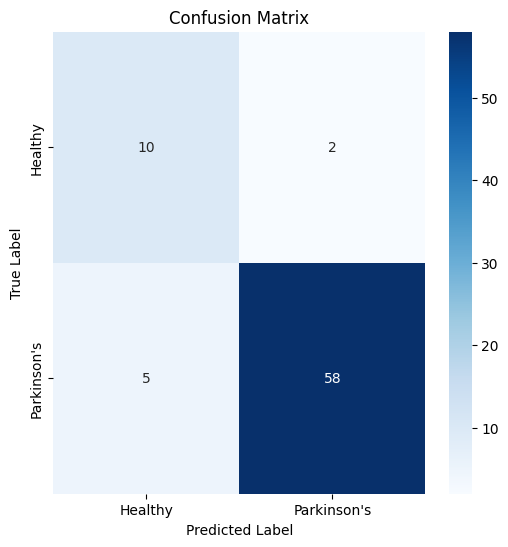

In [ ]:
cm = confusion_matrix(y_test, y_pred)
# Plotting Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Healthy", "Parkinson's"], yticklabels=["Healthy", "Parkinson's"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Plotting Performance Metrics

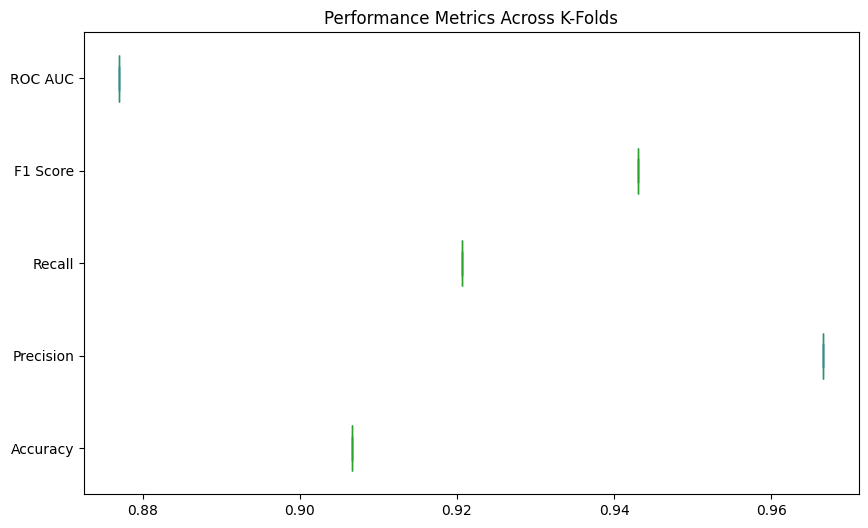

In [ ]:
# Plotting the performance metrics
metrics = {
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores,
    'ROC AUC': roc_auc_scores
}

# Create a DataFrame for easier visualization
metrics_df = pd.DataFrame(metrics)

# Plot the metrics for all folds
metrics_df.plot(kind='box', figsize=(10, 6), vert=False, patch_artist=True)
plt.title('Performance Metrics Across K-Folds')
plt.show()


# Visualizing a Single Decision Tree

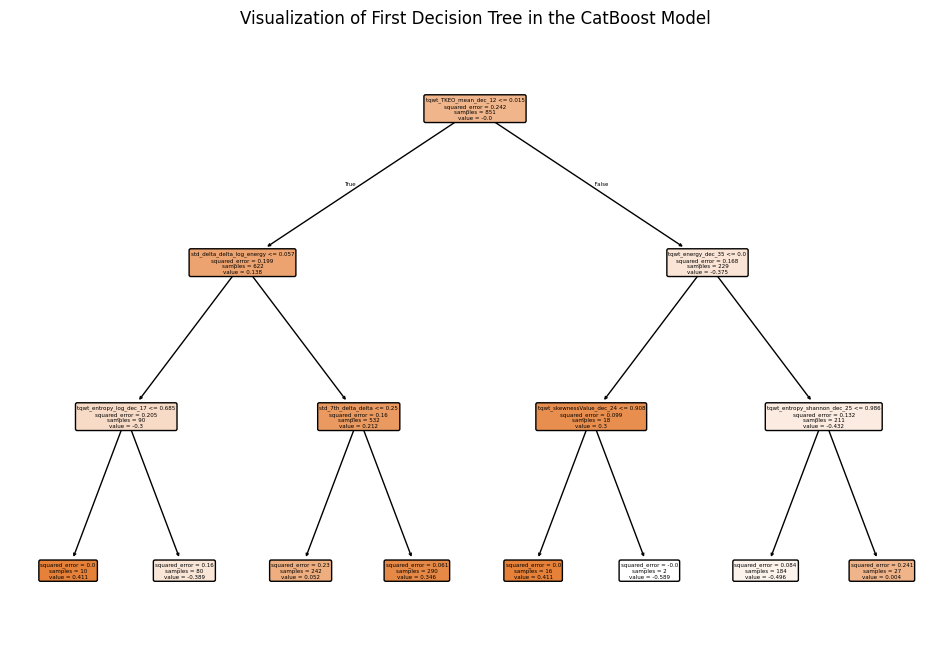

In [ ]:
from sklearn.tree import plot_tree

# Select a specific tree from your model (e.g., the first tree)
tree_to_plot = model.trees[0]  # First tree in the model

# Plot the tree
plt.figure(figsize=(12, 8))
plot_tree(tree_to_plot, filled=True, feature_names=X.columns, class_names=['Class 0', 'Class 1'], rounded=True)
plt.title("Visualization of First Decision Tree in the CatBoost Model")
plt.show()

# split data into training and testing using train_test_split

In [ ]:
# Train on the entire training set (without SMOTE applied) and evaluate on test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [ ]:
# Train the model
final_model = CatBoostScratch(n_estimators=500, learning_rate=0.1, max_depth=3)
final_model.fit(X_res, y_res)

In [ ]:
# Make predictions on the test data
y_pred_final = final_model.predict(X_test)

# Final model evaluation with this splitting data methode (Using Kfold is much better)

In [ ]:
print("Final Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_final):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_final):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_final):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_final):.4f}")
print(classification_report(y_test, y_pred_final))

Final Model Evaluation:
Accuracy: 0.8882
Precision: 0.9076
Recall: 0.9474
F1 Score: 0.9270
ROC AUC Score: 0.8289
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        38
           1       0.91      0.95      0.93       114

    accuracy                           0.89       152
   macro avg       0.86      0.83      0.84       152
weighted avg       0.89      0.89      0.89       152



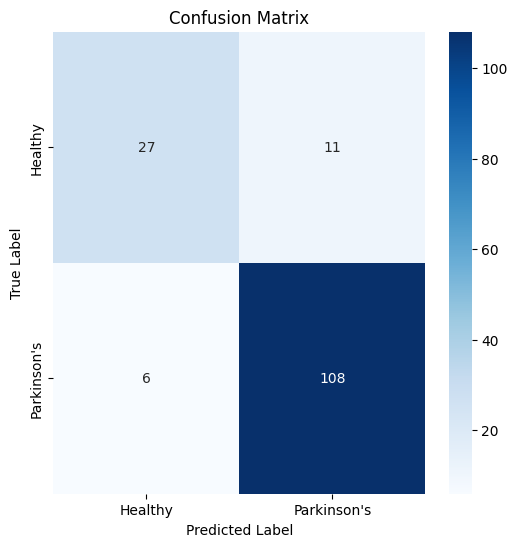

In [ ]:
cm = confusion_matrix(y_test, y_pred_final)
# Plotting Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Healthy", "Parkinson's"], yticklabels=["Healthy", "Parkinson's"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Methode 2 : By feature Selections Using EFSA Algorithme

In [ ]:
%pip install statsmodels



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# backward elimination methode 

In [ ]:
import statsmodels.api as sm

X_res = sm.add_constant(X_res)  # Ajouter la constante

def backward_elimination(X, y, significance_level=0.05):
    features = X.columns.tolist()
    while len(features) > 0:
        X_temp = X[features]
        model = sm.OLS(y, X_temp).fit()  # Train OLS model to get p-values
        p_values = model.pvalues
        print("P-values:", p_values)  # Afficher les p-values à chaque itération
        max_p_value = p_values.max()  # Get the feature with the highest p-value
        if max_p_value > significance_level:
            excluded_feature = p_values.idxmax()  # Get feature to remove
            features.remove(excluded_feature)
            print(f"Removing {excluded_feature} with p-value {max_p_value}")
        else:
            break  # Stop if all features are statistically significant
    return features

# Test de la fonction
selected_features = backward_elimination(X, y)
print(f"Selected features after backward elimination: {selected_features}")
print(f"Selected features after backward elimination: {len(selected_features)}")

P-values: id                           0.034296
gender                       0.084980
PPE                          0.000368
DFA                          0.024980
RPDE                         0.113241
                               ...   
tqwt_kurtosisValue_dec_32    0.803715
tqwt_kurtosisValue_dec_33    0.050568
tqwt_kurtosisValue_dec_34    0.609734
tqwt_kurtosisValue_dec_35    0.203063
tqwt_kurtosisValue_dec_36    0.356158
Length: 754, dtype: float64
Removing tqwt_minValue_dec_22 with p-value 0.9997445025144693
P-values: id                           0.031665
gender                       0.004829
PPE                          0.013149
DFA                          0.020285
RPDE                         0.223852
                               ...   
tqwt_kurtosisValue_dec_32    0.772482
tqwt_kurtosisValue_dec_33    0.030812
tqwt_kurtosisValue_dec_34    0.663648
tqwt_kurtosisValue_dec_35    0.283175
tqwt_kurtosisValue_dec_36    0.330947
Length: 753, dtype: float64
Removing tqwt_minValue_dec

In [ ]:
print(f"Selected features after backward elimination: {len(set(selected_features))}")

Selected features after backward elimination: 278


In [ ]:
print(X_res.shape)  # Vérifie les dimensions de X_res
print(len(X.columns))  # Vérifie le nombre de colonnes dans X

(765, 755)
754


In [ ]:
# X_res = X_res[:, :X.shape[1]]  # Garder les 754 colonnes seulement
# X_res = pd.DataFrame(X_res, columns=X.columns)

In [ ]:
print(type(X_res))  # Devrait afficher <class 'pandas.core.frame.DataFrame'>
print(type(y_res))  # Devrait afficher <class 'pandas.core.series.Series'>

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [ ]:
selected_features_combined = list(set(selected_features).union(set(important_features_with_importance)))

In [ ]:
print(f"Combined features : {important_features_with_importance}")
print(f"Combined features number : {len(selected_features_combined)}")

Combined features : ['std_delta_delta_log_energy', 'tqwt_entropy_log_dec_25', 'tqwt_entropy_log_dec_33', 'mean_MFCC_6th_coef', 'tqwt_entropy_log_dec_27', 'tqwt_TKEO_std_dec_19', 'tqwt_TKEO_std_dec_12', 'std_4th_delta_delta', 'tqwt_energy_dec_6', 'std_7th_delta_delta', 'tqwt_TKEO_std_dec_11', 'mean_MFCC_1st_coef', 'tqwt_minValue_dec_25', 'std_8th_delta_delta', 'tqwt_energy_dec_18', 'tqwt_TKEO_mean_dec_12', 'tqwt_maxValue_dec_7', 'tqwt_minValue_dec_17', 'tqwt_kurtosisValue_dec_20', 'id', 'mean_MFCC_5th_coef', 'std_6th_delta_delta', 'tqwt_entropy_log_dec_35', 'tqwt_energy_dec_16', 'mean_2nd_delta']
Combined features number : 291


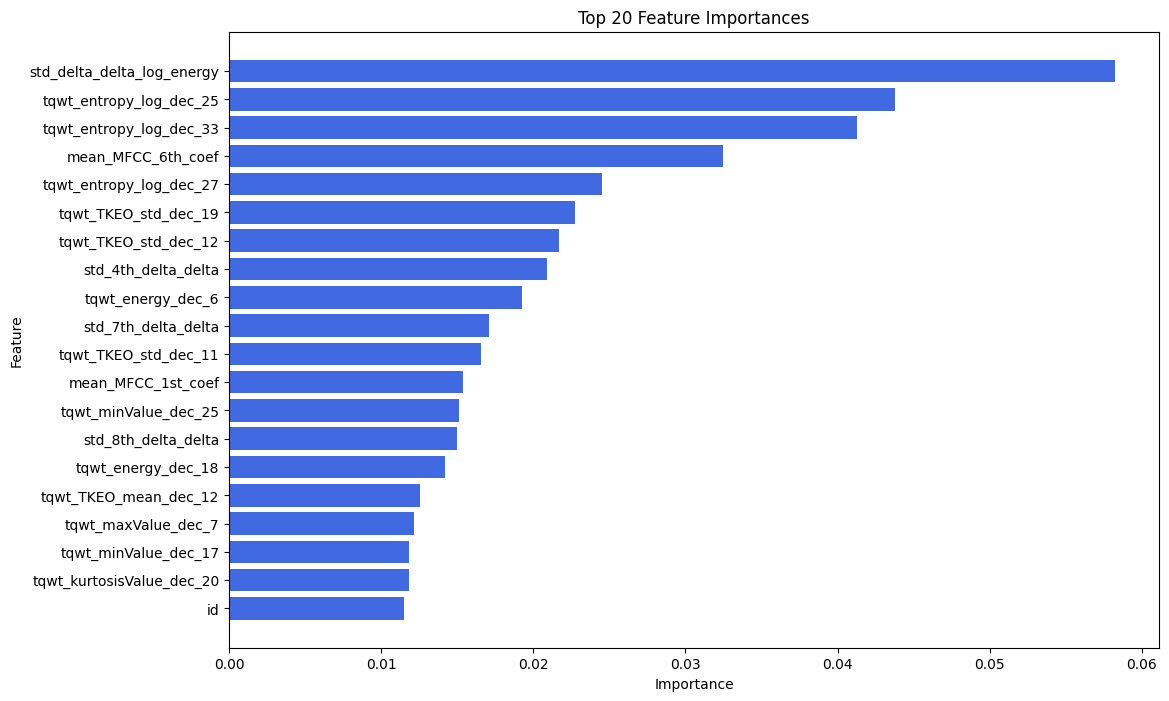

In [ ]:
import matplotlib.pyplot as plt

# Visualize Feature Importances
importances = model.feature_importances_
features = X.columns


# Create a DataFrame for easy sorting and visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

top_n = 20  # Choose the number of top features to display

# Sort features by importance and get the top N
top_features = importance_df.head(top_n)

# Plot the top N features
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='royalblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


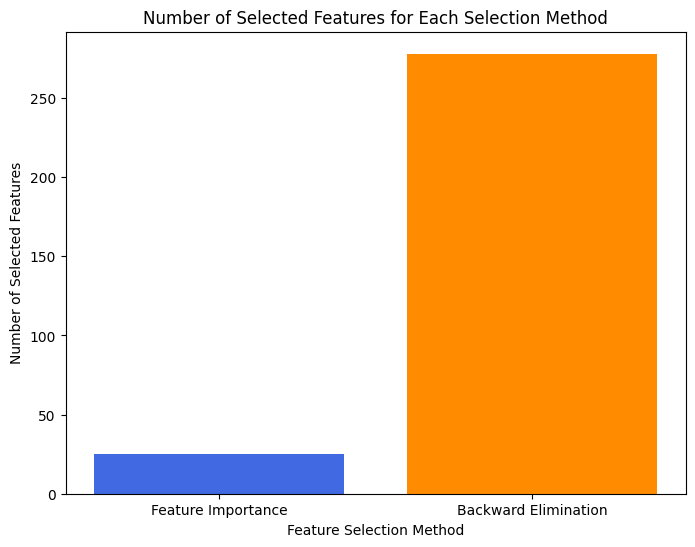

In [ ]:
import matplotlib.pyplot as plt

# Number of selected features for both methods (replace these with your actual counts)
num_selected_features_importance = len(important_features_with_importance)  # e.g., features with importance > threshold
num_selected_features_backward = len(selected_features)  # e.g., selected features from backward elimination

# Create a list of the methods and corresponding feature counts
methods = ['Feature Importance', 'Backward Elimination']
num_features = [num_selected_features_importance, num_selected_features_backward]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(methods, num_features, color=['royalblue', 'darkorange'])

# Adding titles and labels
plt.title('Number of Selected Features for Each Selection Method')
plt.xlabel('Feature Selection Method')
plt.ylabel('Number of Selected Features')

# Display the plot
plt.show()

In [ ]:
X_selected = X_scaled[:, [X.columns.get_loc(feature) for feature in selected_features_combined]]

In [ ]:
print(X_selected.shape)

(756, 291)


In [ ]:
print(type(X_res))

<class 'numpy.ndarray'>


# Trainning with only the selected features 

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
model_imported = CatBoostClassifier(iterations=500, depth=3, learning_rate=0.1, loss_function='Logloss') # with the same parametres as the fromScratch implementation
model_imported.fit(X_res, y_res)

0:	learn: 0.6527601	total: 58.9ms	remaining: 29.4s
1:	learn: 0.5984201	total: 80.1ms	remaining: 19.9s
2:	learn: 0.5643641	total: 99.6ms	remaining: 16.5s
3:	learn: 0.5383658	total: 119ms	remaining: 14.7s
4:	learn: 0.5122990	total: 138ms	remaining: 13.7s
5:	learn: 0.4926439	total: 158ms	remaining: 13s
6:	learn: 0.4757895	total: 179ms	remaining: 12.6s
7:	learn: 0.4578155	total: 203ms	remaining: 12.5s
8:	learn: 0.4407707	total: 231ms	remaining: 12.6s
9:	learn: 0.4302537	total: 255ms	remaining: 12.5s
10:	learn: 0.4210336	total: 284ms	remaining: 12.6s
11:	learn: 0.4098167	total: 313ms	remaining: 12.7s
12:	learn: 0.4005459	total: 338ms	remaining: 12.7s
13:	learn: 0.3869641	total: 364ms	remaining: 12.6s
14:	learn: 0.3752761	total: 387ms	remaining: 12.5s
15:	learn: 0.3661079	total: 415ms	remaining: 12.5s
16:	learn: 0.3575056	total: 441ms	remaining: 12.5s
17:	learn: 0.3500240	total: 466ms	remaining: 12.5s
18:	learn: 0.3446324	total: 490ms	remaining: 12.4s
19:	learn: 0.3409370	total: 514ms	remain

In [ ]:
y_predict = model_imported.predict(X_test)

CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:72: Feature 754 is present in model but not in pool.

In [ ]:
report = classification_report(y_test, y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.58      0.68        38
           1       0.87      0.96      0.91       114

    accuracy                           0.86       152
   macro avg       0.84      0.77      0.79       152
weighted avg       0.86      0.86      0.85       152

